In [1]:
from GeoGuesserSystem import *

In [10]:
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
from shapely import Point

countries_t = system_configs[SYSTEM_ID]['COUNTRIES_T']

countries_all = set([x.split(GLOBAL_DATA_PATH.rsplit('/', 1)[1]+'/')[1].split('/')[0] for x in glob.glob(GLOBAL_DATA_PATH+'/*/*.jpg')])
if countries_t is None:
    countries_t = countries_all

PMD = PreMergerData(GLOBAL_DATA_PATH, countries_all, None)
PMD.preprocess()
shp = PMD.premerged_shapes

DC = DataContainer(shp, GLOBAL_DATA_PATH, countries_all)
DC.load_pictures()
DC.precalculateHaversineDist()

pct = DC.pictures

pct_n = pct['geometry'].apply(lambda x: (x.x, x.y)).values
pct_n = np.array([*pct_n])

shp_n = shp['geometry'].apply(lambda x: (x.centroid.x, x.centroid.y)).values
shp_n = np.array([*shp_n])

DFO = DataFeederOperator(DC.pictures, list(countries_t), countries_all)
DFO.select_data()
DFO.train_test_split(0.2)

res = pd.DataFrame()

for var in ['rg', 'tn', 'tx', 'pr', 'ws', 'pd']:

    print(var)

    xds = rioxarray.open_rasterio('/home/krzysztof-kalisiak/Downloads/EMO-1arcmin-%s_2022.nc' % var)
    scale_factor = xds.scale_factor
    offset = xds.add_offset
    xds = xds.drop_vars('wgs_1984').mean('time').to_dataframe()
    xds = xds.loc[xds[var]>-9000]
    xds = (xds+offset)*scale_factor
    xds['geometry'] = [Point(x[1], x[0]) for x in xds.index.values]
    xds = xds.reset_index(drop=True)
    xds = gpd.sjoin_nearest(DFO.total_images[['geometry']], gpd.GeoDataFrame(xds, geometry=xds['geometry'], crs='EPSG:4326'))
    xds.set_index('geometry', inplace=True, append=True)

    res = pd.concat((res, xds), axis=1)

res.index = res.index.droplevel(1)

res.drop(columns='index_right').rename(columns={'pr':'precipitation', 'ws':'wind_speed', 'tx':'max_temp', 'tn':'min_temp', 'rg':'solar radiation', 'pd':'water vapour pressure'}).to_csv('DATA_OTHER/meteorological2.csv')

rg
tn
tx
pr
ws
pd


In [2]:
shapefile = gpd.read_file(GLOBAL_DATA_OTH_PATH+'NUTS_RG_20M_2021_4326.shp')
shapefile.loc[shapefile['NUTS_ID']=='RO21', 'NAME_LATN'] = 'Nord-Est RO' # there is another nord-est in italy

oecd1 = pd.read_csv('/home/krzysztof-kalisiak/Downloads/OECD1.csv')
oecd2 = pd.read_csv('/home/krzysztof-kalisiak/Downloads/OECD2.csv')

OECD_ = pd.concat([oecd1[['REF_AREA', 'OBS_VALUE']], oecd2[['REF_AREA', 'OBS_VALUE']]], ignore_index=True)

euro_gdp = pd.read_csv('Eurostat_GDP.csv', header=None)[[0, 1]]
euro_gdp.columns = ['NAME_LATN', 'total_gdp']
euro_pop = pd.read_csv('Eurostat_population.csv', header=None)
euro_pop.columns = ['NAME_LATN', 'pop']

euro = euro_gdp.join(euro_pop.set_index('NAME_LATN'), on='NAME_LATN')
euro[['total_gdp', 'pop']] = euro[['total_gdp', 'pop']].apply(lambda x: x.str.replace(',', '').replace(':', 'NaN').astype(float))
euro['GDP'] = (euro['total_gdp']*1000000)/(euro['pop']*1000)

euro = euro[['NAME_LATN', 'GDP']]

euro_gdp = pd.read_csv('Eurostat_GDP.csv', header=None)[[0, 1]]
euro_gdp.columns = ['NAME_LATN', 'total_gdp']
eu = euro_gdp.groupby('NAME_LATN')['total_gdp'].apply(lambda x: x.unique().shape[0])
eu.loc[eu>1]

euro['NAME_LATN'] = euro['NAME_LATN'].apply(lambda x: x.replace(' (NUTS 2021)', ''))

translate_names = {
    'Italy':'Italia',
    'Hungary':'Magyarország',
    'Netherlands':'Nederland',
    'Romania':'România',
    'Sweden':'Sverige',
    'Belgium':'Belgique/België',
    'Czechia':'Česko',
    'Denmark':"Danmark",
    "Germany":'Deutschland',
    "Estonia":"Eesti",
    "Greece":'Elláda',
    "Spain":'España',
    "Croatia":"Hrvatska",
    "Cyprus":'Kýpros',
    'Latvia':'Latvija',
    'Lithuania':'Lietuva',
    'Austria':'Österreich',
    'Poland':'Polska',
    'Slovenia':'Slovenija',
    'Slovakia':'Slovensko',
    'Finland':'Suomi/Finland',
    'Norway':'Norge',
    'Montenegro':'Crna Gora',
    'North Macedonia':'Severna Makedonija',
    'Albania':'Shqipëria',
    'Prov. Brabant wallon':'Région wallonne',
    'Ile de France':'Ile-de-France',
    'Srbija - sever':'Serbia - sever',
    'Beogradski region':'City of Belgrade',
    'Region Vojvodine':'Autonomous Province of Vojvodina',
    'Srbija - jug':'Serbia - jug',
    'Region Sumadije i Zapadne Srbije':'Region Šumadije i Zapadne Srbije',
    'Region Juzne i Istocne Srbije':'Region Južne i Istočne Srbije',
    'Switzerland':'Schweiz/Suisse/Svizzera',
    'Svalbard og Jan Mayen':'Jan Mayen and Svalbard'
}

euro['NAME_LATN'] = euro['NAME_LATN'].apply(lambda x: translate_names.get(x, x))

euro = euro.loc[(euro['NAME_LATN']!='European Union - 27 countries (from 2020)') 
                & ~euro['NAME_LATN'].str.contains('Extra')
                & (euro['NAME_LATN']!='Svalbard og Jan Mayen')]

euro = euro.join(shapefile.set_index('NAME_LATN')['FID'], on='NAME_LATN')

translate = {'LUX':"LU", 'LTU':'LT', 'LVA':'LV', 'ITA':'IT', 'POL':'PL', 'NLD':'NL', 
             'SWE':'SE', 'ESP':'ES', 'SVN':'SI', 'SVK':'SK', 'PRT':"PT", 'TUR':'TR', 'GBR':'UK', 'CHE':'CH', 
             'NOR':'NO', 'DNK':'DK', 'CZE':'CZ', 'AUT':"AT", 'FIN':'FI', 'IRL':"IE", 'HUN':'HU', 'GRC':"EL", 'DEU':'DE', 'FRA':'FR', 'EST':'EE', 'BEL':'BE', 'ISL':"IS"}

OECD_['REF_AREA'] = OECD_['REF_AREA'].apply(lambda x: translate[x] if x in translate else x)
OECD = OECD_.join(shapefile[['FID', 'NAME_LATN']].set_index('FID'), on='REF_AREA')
OECD.columns = ['FID', 'GDP', 'NAME_LATN']
OECD = OECD[['NAME_LATN', 'GDP', 'FID']]

full = pd.concat([OECD, euro], ignore_index=True)
full = full.groupby('FID').agg({'NAME_LATN':'first', 'GDP':'mean'}).reset_index()
full.loc[len(full)] = ['LI', 'Liechtenstein', 187267.1]
full.loc[len(full)] = ['LI0', 'Liechtenstein', 187267.1]
full.loc[len(full)] = ['LI00', 'Liechtenstein', 187267.1]
full.loc[len(full)] = ['IS0', 'Ísland', 73466.78]
full.loc[len(full)] = ['IS00', 'Ísland', 73466.78]

s2 = shapefile.join(full.set_index('FID'), on='FID', rsuffix='_r').drop(columns='NAME_LATN_r')

s2['GDP'] = s2['GDP'].apply(lambda x: np.nan if np.isinf(x) else x)

s2['parent_code'] = s2['FID'].str[:-1]
s2_0 = s2.loc[s2['LEVL_CODE']==0]
s2_1 = s2.loc[s2['LEVL_CODE']==1]
s2_2 = s2.loc[s2['LEVL_CODE']==2]
s2_3 = s2.loc[s2['LEVL_CODE']==3]

s2_1 = s2_1.join(s2_0.set_index("FID")['GDP'], on='parent_code', rsuffix='parent_level0')
s2_2 = s2_2.join(s2_1.set_index("FID")[['GDP', 'GDPparent_level0']], on='parent_code', rsuffix='parent_level1')
s2_3 = s2_3.join(s2_2.set_index("FID")[['GDP', 'GDPparent_level0', 'GDPparent_level1']], on='parent_code', rsuffix='parent_level2')

s2_3['final_GDP_proxy'] = s2_3[['GDP', 'GDPparent_level2', 'GDPparent_level1', 'GDPparent_level0']].bfill(axis=1).iloc[:, 0]
s2_3["final_GDP_proxy"] = s2_3["final_GDP_proxy"].clip(upper=s2_3["final_GDP_proxy"].quantile(0.95))

s2_3['centroid_loc'] = s2_3.centroid

BR = system_loader()

pdc = pd.concat([BR.train_dataloader.dataset.img_dir, BR.test_dataloader.dataset.img_dir]).sort_index()

GDPs = []

for i in tqdm.tqdm(range(pdc.shape[0])):
    country_code = pdc.iloc[i].NUTS_ID_fin[:2]

    selected_country = s2_3.loc[s2_3['CNTR_CODE']==country_code]


    non_normalized_weights = 1/selected_country.centroid_loc.distance(pdc.iloc[i].geometry)
    normalized_weights = non_normalized_weights/non_normalized_weights.sum()

    GDP = np.sum(normalized_weights.values * selected_country.final_GDP_proxy.values)

    GDPs.append(GDP)

pdc['GPD'] = GDPs
pdc['GPD'].to_csv('DATA_OTHER/GDP2.csv')

100%|██████████| 187622/187622 [23:28<00:00, 133.16it/s]


In [34]:
save_system(BR)

In [3]:
BR.train(500)

NameError: name 'BR' is not defined

In [8]:
BR.generate_test_main()

100%|██████████| 15/15 [00:00<00:00, 152.91it/s]


IndexError: index 1 is out of bounds for dimension 0 with size 1

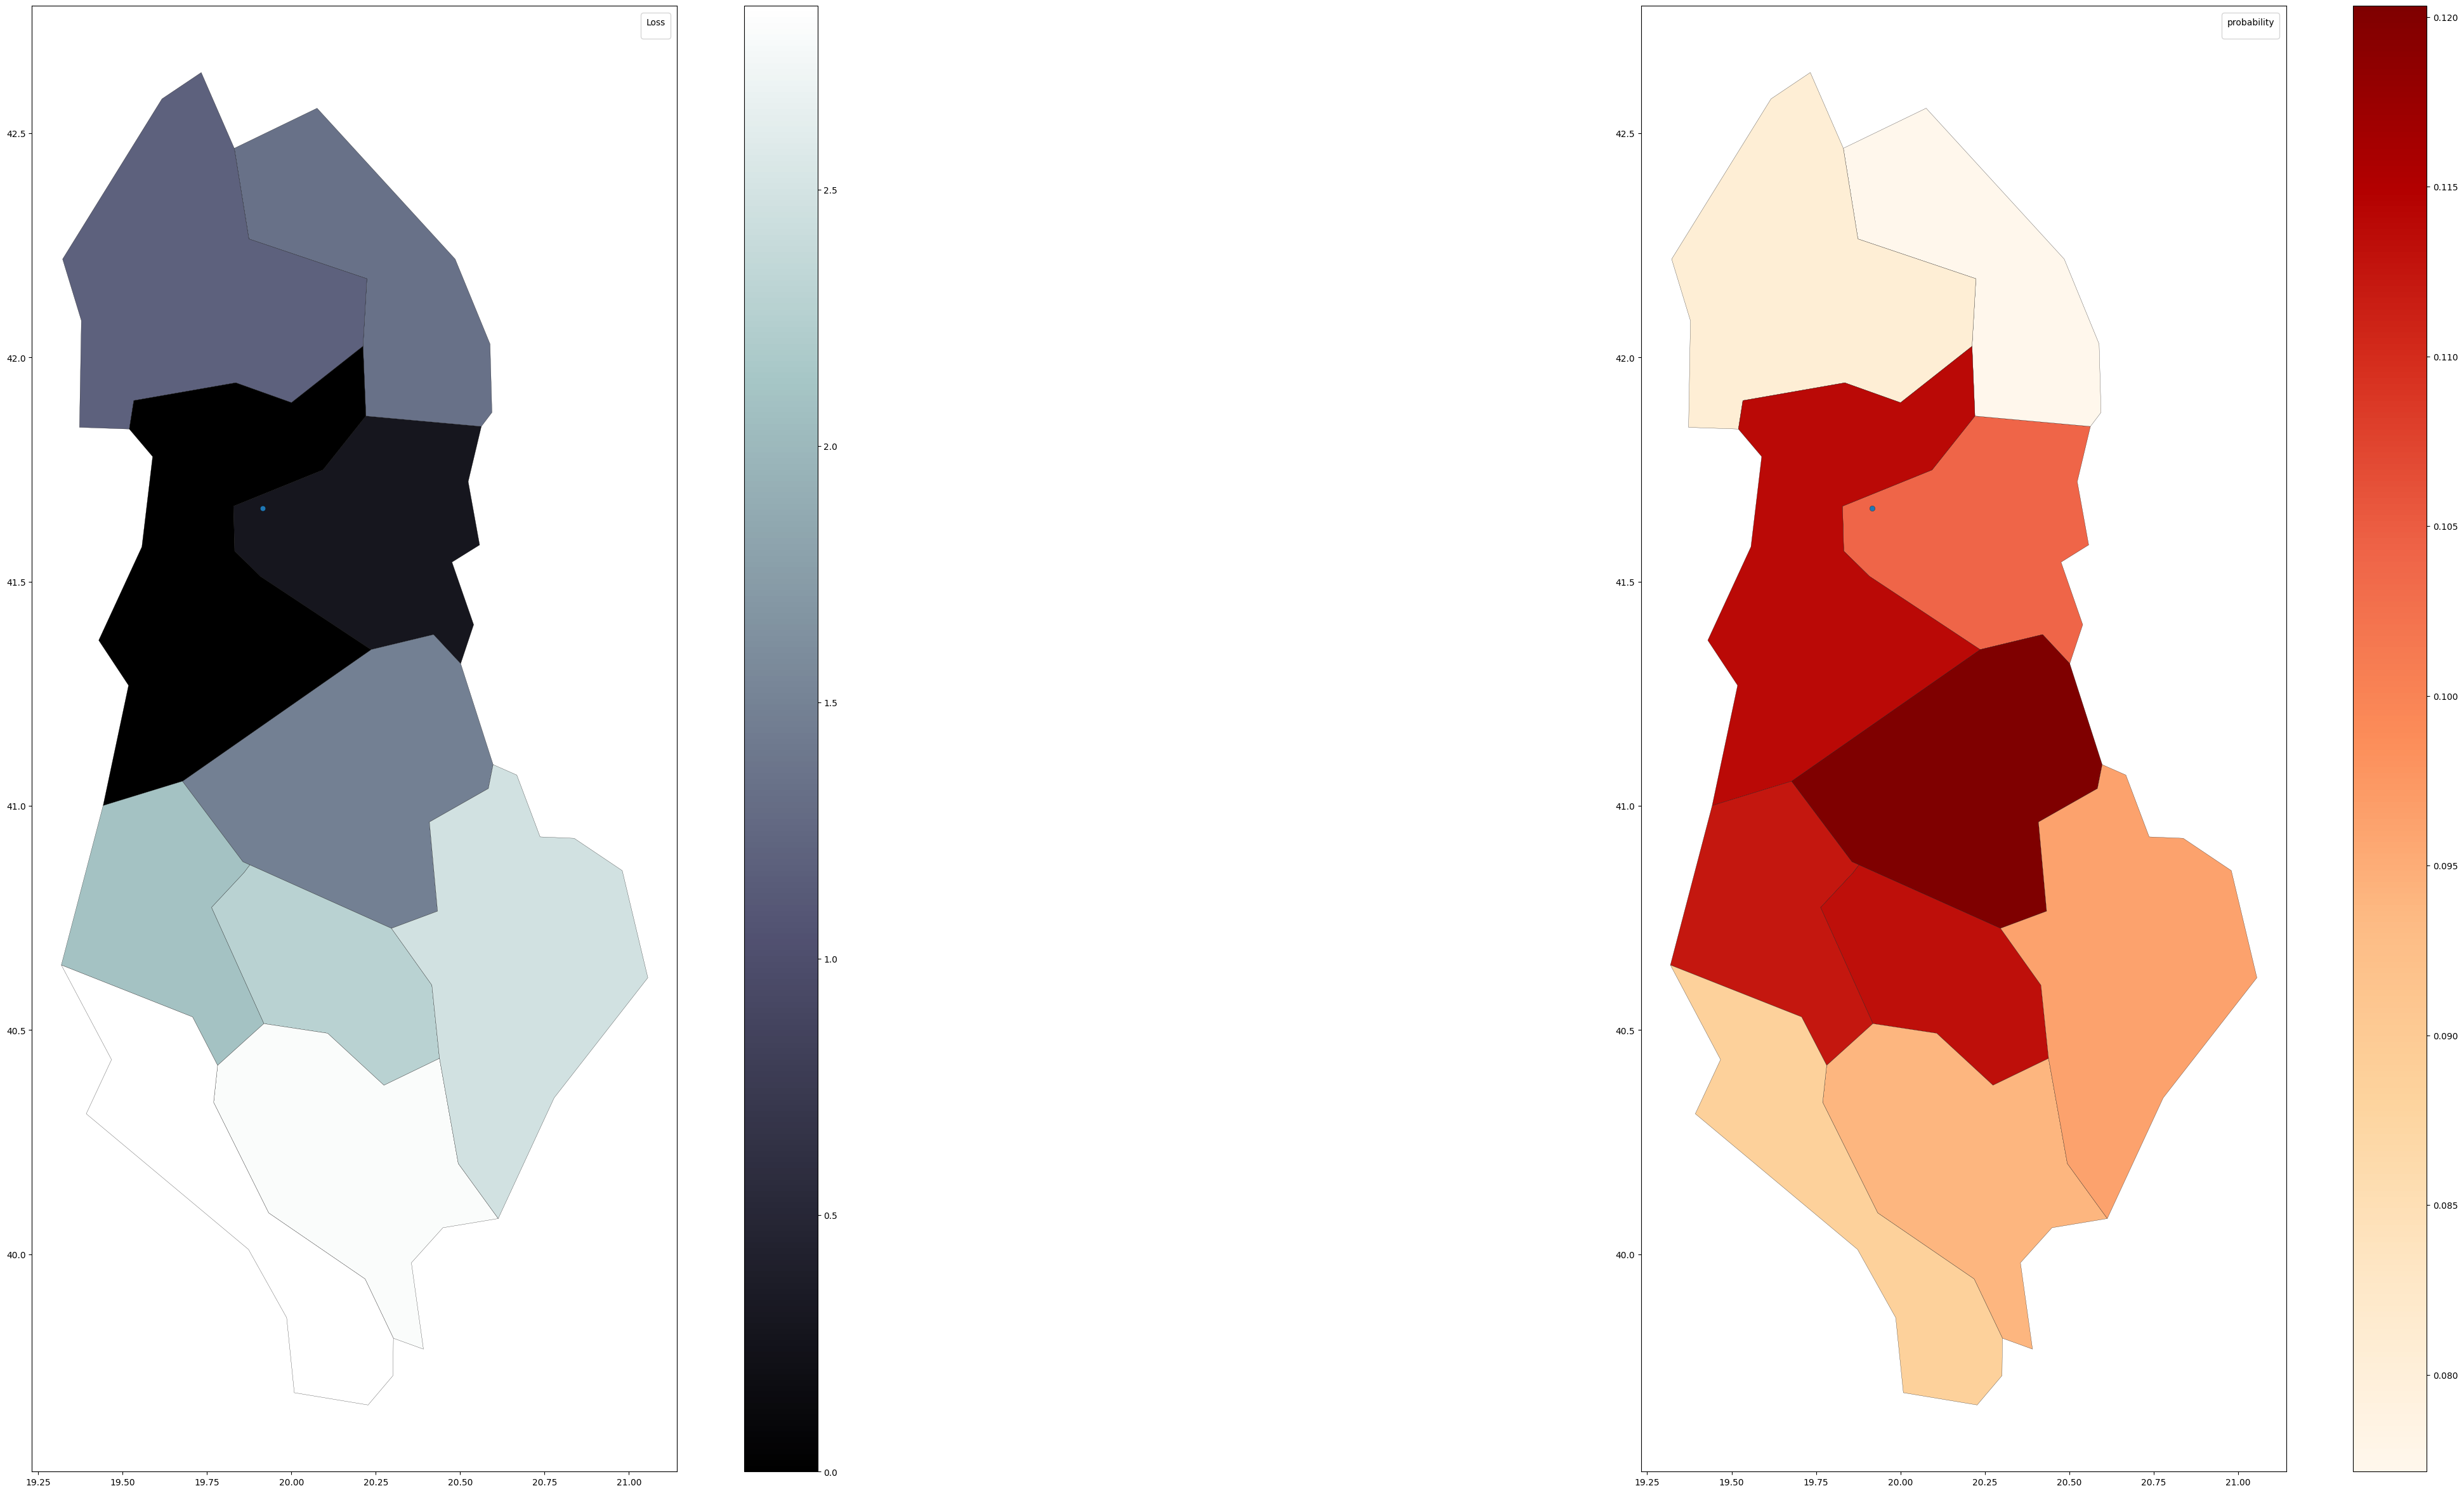

In [17]:
loss_prop, gradient_analysis = BR.asses_photos(data=next(iter(BR.test_dataloader)))

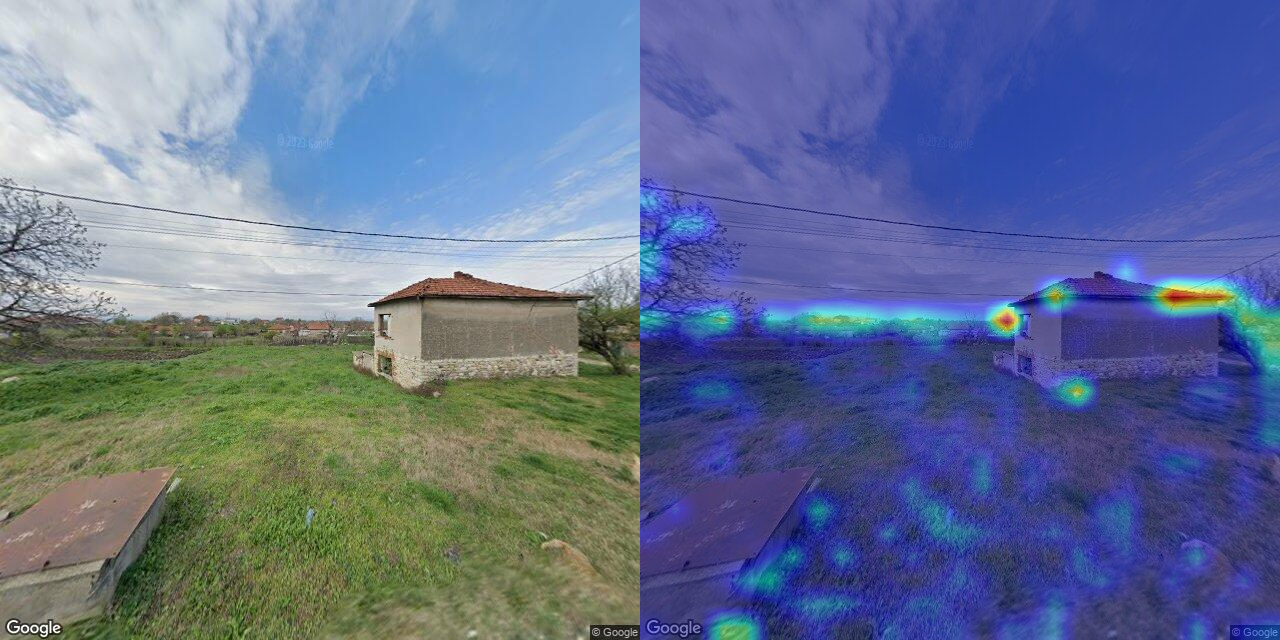

In [10]:
gradient_analysis[-7]

In [10]:
BR.metrics_and_plots()

IndexError: index 1 is out of bounds for axis 0 with size 1